# Tiền xử lý và làm sạch dữ liệu (Không loại bỏ outliers)

Notebook này thực hiện tiền xử lý và làm sạch dữ liệu từ file `extracted_features.csv` mà không loại bỏ outliers, phù hợp với tập dữ liệu nhỏ. Các bước bao gồm:
- Đọc dữ liệu
- Kiểm tra giá trị thiếu, trùng lặp, và kiểu dữ liệu
- Xử lý giá trị thiếu bằng median (ít nhạy cảm với outliers)
- Xóa các hàng trùng lặp
- Đảm bảo các cột tần số (Fo, Fhi, Flo) có giá trị dương
- Chuẩn hóa dữ liệu bằng RobustScaler
- Visualize phân bố dữ liệu
- Lưu file đã xử lý (`cleaned_features_no_outliers.csv`)

## Thư viện cần thiết
Chạy cell dưới đây để import các thư viện cần thiết.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

# Đọc dữ liệu từ file CSV
df = pd.read_csv('../data/extracted_features.csv')

## Kiểm tra dữ liệu
Kiểm tra thông tin cơ bản của dữ liệu, bao gồm kiểu dữ liệu, thống kê mô tả, giá trị thiếu, và trùng lặp.

In [12]:
# Thông tin dữ liệu
print("Thông tin dữ liệu:")
print(df.info())

# Thống kê mô tả
print("\nThống kê mô tả:")
print(df.describe())

# Kiểm tra giá trị thiếu
print("\nGiá trị thiếu:")
print(df.isnull().sum())

# Kiểm tra trùng lặp
print("\nSố hàng trùng lặp:", df.duplicated().sum())

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621 entries, 0 to 620
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MDVP:Fo(Hz)          621 non-null    float64
 1   MDVP:Fhi(Hz)         621 non-null    float64
 2   MDVP:Flo(Hz)         621 non-null    float64
 3   MDVP:Jitter(%)       621 non-null    float64
 4   MDVP:Jitter(Abs)     621 non-null    float64
 5   MDVP:RAP             621 non-null    float64
 6   MDVP:PPQ             621 non-null    float64
 7   Jitter:DDP           621 non-null    float64
 8   MDVP:Shimmer         621 non-null    float64
 9   MDVP:Shimmer(dB)     621 non-null    float64
 10  Shimmer:APQ3         621 non-null    float64
 11  Shimmer:APQ5         621 non-null    float64
 12  MDVP:APQ             619 non-null    float64
 13  Shimmer:DDA          621 non-null    float64
 14  HNR                  621 non-null    float64
 15  NHR                  

## Visualize phân bố dữ liệu
Vẽ boxplot và histogram để kiểm tra phân bố và xác định outliers (không loại bỏ).

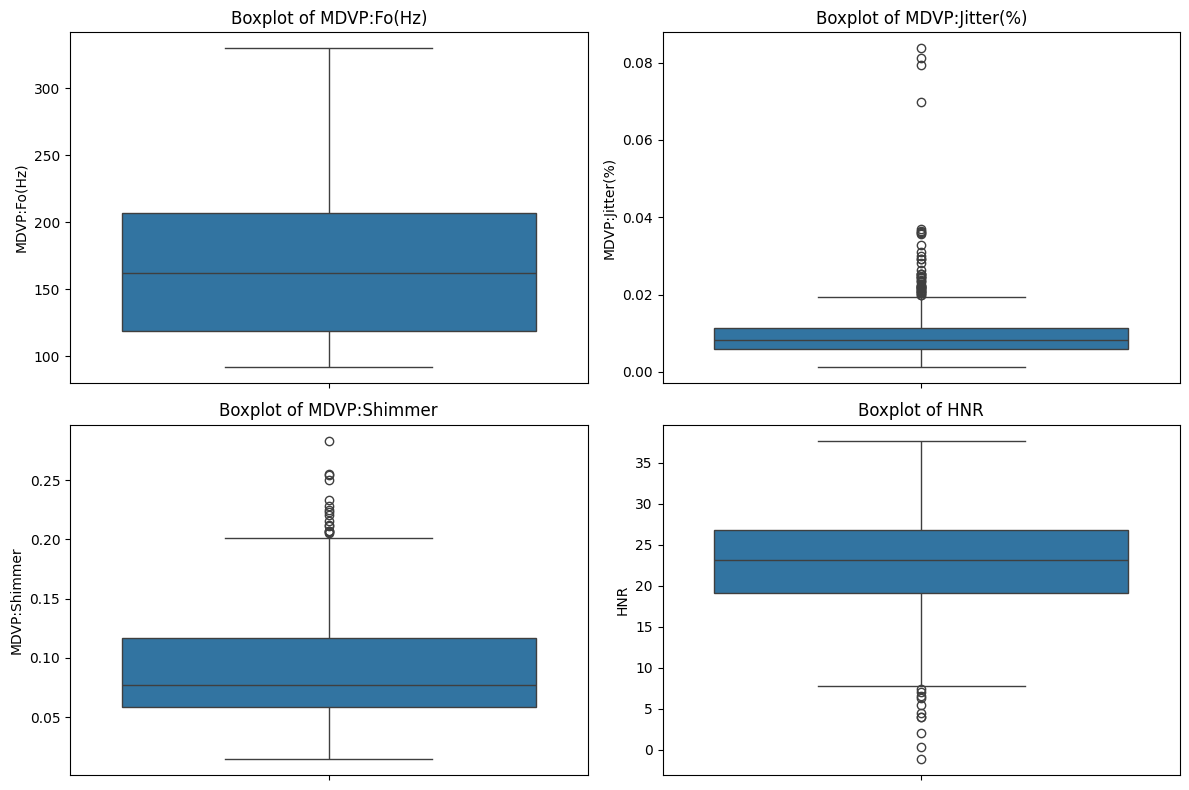

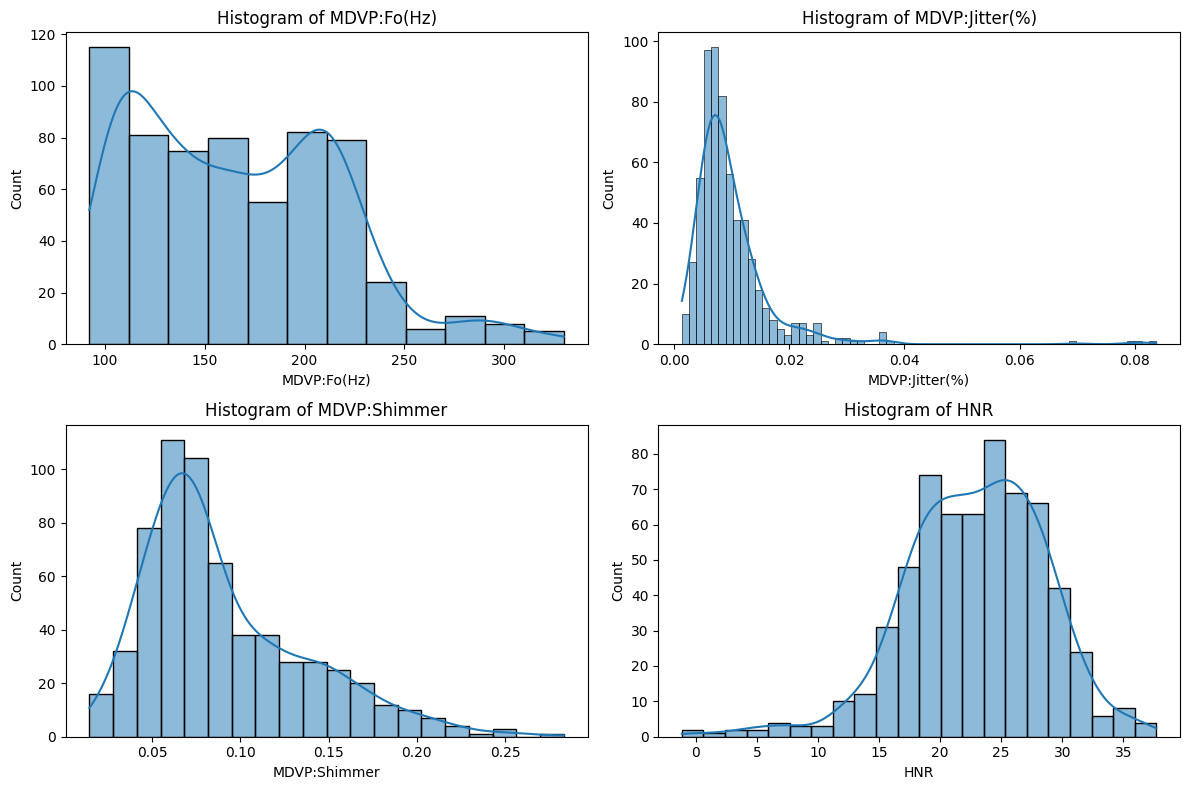

In [13]:
# Vẽ boxplot cho một số cột chính
plt.figure(figsize=(12, 8))
for i, col in enumerate(['MDVP:Fo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Shimmer', 'HNR']):
    plt.subplot(2, 2, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# Vẽ histogram
plt.figure(figsize=(12, 8))
for i, col in enumerate(['MDVP:Fo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Shimmer', 'HNR']):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.show()

## Làm sạch dữ liệu
- Điền giá trị thiếu bằng median (ít nhạy cảm với outliers).
- Xóa các hàng trùng lặp.
- Đảm bảo các cột tần số (Fo, Fhi, Flo) có giá trị dương.

In [14]:
# Chọn các cột số (trừ 'class')
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('class')

# Xử lý giá trị thiếu bằng median
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Xóa duplicates
df = df.drop_duplicates()

# Đảm bảo tần số dương
freq_cols = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)']
df = df[(df[freq_cols] > 0).all(axis=1)]

print("Shape sau khi làm sạch:", df.shape)

Shape sau khi làm sạch: (621, 36)


## Tiền xử lý
- Loại bỏ cột `id` nếu không cần cho mô hình.
- Tách đặc trưng (X) và nhãn (y).
- Chuẩn hóa dữ liệu sử dụng RobustScaler (ít nhạy cảm với outliers).
- Tùy chọn: Chia dữ liệu thành tập train/test (80/20).

In [15]:
# Drop cột id
df_clean = df.drop(columns=['id'])

# Tách X và y
X = df_clean.drop(columns=['class'])
y = df_clean['class']

# Chuẩn hóa X bằng RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Chuyển về DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Kết hợp lại với y
df_preprocessed = pd.concat([X_scaled_df, y.reset_index(drop=True)], axis=1)

# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print("Dữ liệu sau tiền xử lý (5 hàng đầu):")
print(df_preprocessed.head())
print("\nShape của dữ liệu đã tiền xử lý:", df_preprocessed.shape)
print("\nPhân bố class:")
print(y.value_counts())

Dữ liệu sau tiền xử lý (5 hàng đầu):
   MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
0    -0.035253      0.053413      0.094200       -0.761456         -0.580233   
1    -0.031434     -0.219925      0.122919       -0.764121         -0.583417   
2    -0.022918     -0.217136      0.122484       -0.658604         -0.507314   
3    -0.011442     -0.131888      0.085888       -0.428556         -0.340733   
4     0.052048      0.428652      0.209156       -0.617711         -0.501578   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
0 -0.797863 -0.826992   -0.797863      0.045296          0.040498  ...   
1 -0.743564 -0.794309   -0.743564     -0.048798         -0.051833  ...   
2 -0.654079 -0.697052   -0.654079      0.009917          0.018749  ...   
3 -0.449565 -0.470898   -0.449565      0.105542          0.143966  ...   
4 -0.599106 -0.649212   -0.599106     -0.290109         -0.282091  ...   

   mean_MFCC_4th_coef  mean_MFCC_5th_

## Lưu file kết quả
Lưu dữ liệu đã tiền xử lý vào file `cleaned_features_no_outliers.csv`.

In [ ]:
# Lưu file
df_preprocessed.to_csv('../data/cleaned_features.csv', index=False)
print("File cleaned_features_no_outliers.csv đã được lưu.")

File cleaned_features_no_outliers.csv đã được lưu.
